# Use this code if your naming convention is customized and 3D. Applicable only for Nifti files. 


### First import libraries
 For those new to Jupyter Notebook, use shift + enter to run the cell or the play button in the toolbar above


In [7]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil
import tensorflow

Here we are pre-defining some functions to use later

In [2]:
# figure out difference that needs to be made up in rows/columns
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

#after calculating the padding, add in the padding to rows and columns to meet new expected size
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [3]:
def gather_by_name(orignal_path, new_path, phrase):
    n=0
    file_list=[]
    for root, dirs, files in os.walk(os.path.normpath(original_path), topdown=True):
        for name in files:
            if phrase in name:
                file_list.append(os.path.join(root,name))                
                
    for j in range(len(file_list)):
        filename = file_list[j]
        shutil.copy(filename, new_path)

   

    print('copied and moved '+ str(len(file_list))+' files')

In [4]:
def gather_filenames(path):
    raw_path = path
    patient_folders = []
    pt_fnames = []

    import os
    for root, dirs, files in os.walk(os.path.normpath(raw_path), topdown=True):
        for name in files: 
            #print(os.path.join(root, name))
            pt_fnames.append(os.path.join(root, name))
    print('\nPatient Folders have been identified\n')
    #sort through and get only the files with ROI in them
    #this eliminates the tiff and 3D files 
    #%%
    ROI_list = []
    for j in range(len(pt_fnames)):
        ROI_name = 'ROI'
        filename = os.path.basename(pt_fnames[j])
        if ROI_name in filename:
            ROI_list.append(pt_fnames[j])
    print('\nFilenames have been found and added\n')
    print('copied and moved '+ str(len(ROI_list))+' files')
    
    return ROI_list

In [5]:
def convert_NPY_NII(ROI_list):
    #new_size= new_size
    print('Converting', str(len(ROI_list)), 'files')
    for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
        orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
        print(orig_fname)
        #extract information from the filename
        if orig_fname[0].isdigit(): 
            orig_fname = orig_fname
        else:
            orig_fname = orig_fname[3:]
        num_slice = int(orig_fname[-3:])
        #print(num_slice)
        if num_slice < 15:
            orig_fname = this_list[2]
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-7:-4]))
            #print(num_width)
            num_height = int((orig_fname[-11:-8]))
        elif num_slice < 50:
            #print('over 99')
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-8:-4]))
            #print(num_width)
            num_height = int((orig_fname[-12:-8]))
            #print(num_height)
        else:
            #print('less than 99')
            num_width = int((orig_fname[-7:-3]))
            #print(num_width)
            num_height = int((orig_fname[-11:-7]))
            #print(num_height)
        pt_numb =(orig_fname[0:6])
        if orig_fname[8].isdigit():
            yr_numb = (orig_fname[8])
        else:
            yr_numb = orig_fname[7]
        if 'Cyst' in orig_fname:
            img_type = 'C'
        elif 'Kidney' in orig_fname:
            img_type = 'M_K'
        elif 'Image' in orig_fname:
            img_type = 'M'
        if 'Right' in orig_fname:
            side = 'R'
        elif 'Left' in orig_fname:
            side = 'L'
        call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
        resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
        transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
        with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
             data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
             for j in range(num_slice):
                 orig_slice = data[j]
                 re_slice = Image.fromarray(orig_slice)
                 resized[j] = resize_with_padding(re_slice, (new_size, new_size))
             for i in range(resized.shape[0]):
                 old_slice = resized[i,:,:]
                 transposed[:,:,i] = old_slice

                 # now we need to rename this resized array and save it as a .npy
        #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
        new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
        file_name = "%s" %new_fname # add our extension
        np.save(os.path.join(new_path, file_name), transposed)
        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))
 

    print("complete --- nice job")

In [6]:
img = np.load(r"C:\Users\UAB\data\Emory\data\EM_200922_0_144_L_29_M.npy")

In [7]:
img.dtype

dtype('uint8')

## FilePath Input
Fill in the filepaths for the raw data, the new path to store the npy files, and the final path for the images and annotations 
Make sure to fill out the new sizing as the complete size with zero padding

In [23]:
raw_path = r'C:\Users\UAB\data\Mayo\Original\issues solved'
new_path = r'D:\Data\Mayo\NPY'
final_path = r'D:\Data\Mayo\NII'

new_size = 128

In [24]:
#remove .tif files

In [25]:
this_list = gather_filenames(raw_path)


Patient Folders have been identified


Filenames have been found and added

copied and moved 192 files


In [26]:
orig_fname = this_list[2]
num_slice = int(orig_fname[-3:])
num_width = int((orig_fname[-7:-4]))
            #print(num_width)
num_height = int((orig_fname[-11:-8]))

print(num_slice, num_width, num_height)

133 175 128


In [27]:
print(len(this_list))
print(this_list[1])

192
C:\Users\UAB\data\Mayo\Original\issues solved\313307 0  Cyst ROI Right 8bit 125 168 133


In [28]:
convert_NPY_NII(this_list) 

Converting 192 files
313307 0  Cyst ROI Left 8bit 128 175 133
313307 0  Cyst ROI Right 8bit 125 168 133
313307 0  Image ROI Left 8bit 128 175 133
313307 0  Image ROI Right 8bit 125 168 133
313307 0  Kidney ROI Left 8bit 128 175 133
313307 0  Kidney ROI Right 8bit 125 168 133
313307 1  Cyst ROI Left 8bit 133 188 140
313307 1  Cyst ROI Right 8bit 127 173 140
313307 1  Image ROI Left 8bit 133 188 140
313307 1  Image ROI Right 8bit 127 173 140
313307 1  Kidney ROI Left 8bit 133 188 140
313307 1  Kidney ROI Right 8bit 127 173 140
313307 2 Cyst ROI Left 8bit 147 200 147
313307 2 Cyst ROI Right 8bit 126 171 147
313307 2 Image ROI Left 8bit 147 200 147
313307 2 Image ROI Right 8bit 126 171 147
313307 2 Kidney ROI Left 8bit 147 200 147
313307 2 Kidney ROI Right 8bit 126 171 147
313307 3 Cyst ROI Left 8bit 138 195 161
313307 3 Cyst ROI Right 8bit 124 176 161
313307 3 Image ROI Left 8bit 138 195 161
313307 3 Image ROI Right 8bit 124 176 161
313307 3 Kidney ROI Left 8bit 138 195 161
313307 3 Kidne

## Re-assign Masks
Move the masks to a new location in the file structure desired

In [6]:
import os
import shutil
#path = r"C:\Users\UAB\data\UAB\data"
#cyst_path = r'D:\CK_Segmentation Codes\Test Images\UAB\457026_L'
path = r'D:\Data\Emory\data'
cyst_path = r'D:\Data\Emory\data1'
cyst_names=[]
for root, dirs, files in os.walk(os.path.normpath(path), topdown=True):
    for name in files:
        #print(os.path.join(root, name))
        cyst_names.append(os.path.join(root, name))

C_list = []
for j in range(len(cyst_names)):
    C_name = 'M.'    
    #R_name = '457036_'
    filename = os.path.basename(cyst_names[j])
    if C_name in filename:
    #if C_name and R_name in filename:
        C_list.append(cyst_names[j])

for i in range(len(C_list)):
    #shutil.copy(C_list[i],cyst_path )
    shutil.move(C_list[i],cyst_path )

In [34]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_80-10_35ep_K' in f:
        continue
      if '_K.' in f:
        continue
      if '_C.' in f:
        continue
      else:
        set_of.append(f)
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [24]:
data_path = r'C:\Users\UAB\data\UAB\data'
final_path1 = r'D:\Data\UAB\NPY_Reshaped'
final_path2 = r'D:\Data\UAB\NII_Reshaped'
labels = gather_set(data_path, '_M.')
print(len(labels))

7278


In [25]:
for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-6]
    new_fname = str(file_name +'_M')
    save_slice = working_img.reshape((512,512,1))
    np.save(os.path.join(final_path1, new_fname), save_slice)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(save_slice, affine)
    name = str(file_name +'_M')
    nib.save(nifti_file, os.path.join(final_path2, name))
  

In [32]:
m = np.load(r"D:\Data\UAB\NPY_Reshaped\UB_407132_0_95_L_6_K.npy")
m.min()

0

# Stack NPY Images 

In [46]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [35]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [49]:
data_path = r'D:\Data\Mayo\NPY_Sliced'
#data_path= r'C:\Users\UAB\data\UAB\AllNIIImages'
new_path = r'D:\Data\Mayo\data'
new_path1 = r'D:\Data\Mayo\nii1'
labels = gather_set(data_path, '_M.')
print(len(labels))
for i in range(len(labels)):
    a = np.load(data_path + '\\' + labels[i])
    b=np.dstack([a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a])
    file_name = labels[i][:-5]
    name = str(file_name +'M')
    name2 = str(file_name +'M')    
    np.save(os.path.join(new_path, name), b)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(b, affine)
    nib.save(nifti_file, os.path.join(new_path1, "%s" %name2))
    

21541


# Reshape NII Images


In [3]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of


In [24]:
data_path = r'D:\Data\KU\NPY_Sliced'
#data_path= r'C:\Users\UAB\data\UAB\AllNIIImages'
new_path = r'D:\Data\KU\npy1'
new_path1 = r'D:\Data\KU\nii1'
labels = gather_set(data_path, '_M.')
print(len(labels))
for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    m1 = working_img.reshape((128,128,1))
    file_name = labels[i][:-5]
    name = str(file_name +'M')
    name2 = str(file_name +'M')    
    np.save(os.path.join(new_path, name), m1)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(m1, affine)
    nib.save(nifti_file, os.path.join(new_path1, "%s" %name2))
    i+=1

26454


In [26]:
import numpy as np
import nibabel as nib
from nilearn.image import resample_img
data_path = r'D:\Data\KU\nii1'
#data_path= r'C:\Users\UAB\data\UAB\AllNIIImages'
new_path = r'D:\Data\KU\nii2'
new_path1 = r'D:\Data\KU\npy2'
images = gather_set(data_path, '_K.')
print(len(images))
for i in range(len(images)):
    
    working_img = nib.load(data_path + '\\' + images[i])
    affine = working_img.affine

    nii_image = resample_img(working_img, affine, (128,128,32))
    file_name = images[i][:-5]
    new_fname = str(file_name + 'K')
    nib.save(nii_image, os.path.join(new_path, new_fname))
    print(nii_image.shape)
    npy_image = nii_image.get_fdata()
    np.save(os.path.join(new_path1, new_fname), npy_image)
    print(npy_image.shape)


26454
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128,

(128, 128)

In [51]:
import numpy as np
import nibabel as nib
from nilearn.image import resample_img
data_path = r'D:\Data_3D\Emory\NII'
new_path = r'D:\Data_3D\Emory\NII_Reshaped'
new_path1 = r'D:\Data_3D\Emory\NPY_Reshaped'
images = gather_set(data_path, '_C.')
print(len(images))
for i in range(len(images)):
    working_img = nib.load(data_path + '\\' + images[i])
    print(working_img.shape)
    target_shape = np.array((256,256,128))
    new_resolution = [1,]*3
    new_affine = np.zeros((4,4))
    new_affine[:3,:3] = np.diag(new_resolution)
    # putting point 0,0,0 in the middle of the new volume - this could be refined in the future
    new_affine[:3,3] = target_shape*new_resolution/2.*0
    new_affine[3,3] = 1
    nii_image = resample_img(working_img, target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
    file_name = images[i][:-6]
    new_fname = str(file_name + '_C')
    
    print(nii_image.shape)
    npy_image = nii_image.get_fdata()
    np.save(os.path.join(new_path1, new_fname), npy_image)
    print(npy_image.shape)


215
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 138)
(256, 256, 128)
(256, 256, 128)
(256, 256, 138)
(256, 256, 128)
(256, 256, 128)
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 144)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 132)
(256, 256, 128)
(256

(256, 256, 128)
(256, 256, 128)
(256, 256, 84)
(256, 256, 128)
(256, 256, 128)
(256, 256, 84)
(256, 256, 128)
(256, 256, 128)
(256, 256, 84)
(256, 256, 128)
(256, 256, 128)
(256, 256, 96)
(256, 256, 128)
(256, 256, 128)
(256, 256, 96)
(256, 256, 128)
(256, 256, 128)
(256, 256, 99)
(256, 256, 128)
(256, 256, 128)
(256, 256, 99)
(256, 256, 128)
(256, 256, 128)
(256, 256, 102)
(256, 256, 128)
(256, 256, 128)
(256, 256, 102)
(256, 256, 128)
(256, 256, 128)
(256, 256, 114)
(256, 256, 128)
(256, 256, 128)
(256, 256, 114)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 108)
(256, 256, 128)
(256, 256, 128)
(256, 256, 99)
(256, 256, 128)
(256, 256, 128)
(256, 256, 99)
(256, 256, 128)
(256, 256, 128)
(256, 256, 135)
(256, 256, 128)
(256, 256, 128)
(256, 256, 135)
(

# Slicing NII Images


In [40]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of



In [44]:
data_path = r'D:\Data\Mayo\NII'
main = r'D:\Data\Mayo\NII_Sliced'
images = gather_set(data_path, '_M.')
for i in range(len(images)):
    working_img = nib.load(data_path + '\\' + images[i])
    working_img = working_img.get_fdata()
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(save_slice, affine)
        nib.save(nifti_file, os.path.join(main, "%s" %new_fname))
        

In [45]:
data_path = r'D:\Data\Mayo\NPY'
main2 = r'D:\Data\Mayo\NPY_Sliced'
labels = gather_set(data_path, '_M.')

for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        np.save(os.path.join(main2, new_fname), save_slice)

## Binarize masks
first gather the set based on the naming convention above, then binarize and save in a different location

In [5]:
final_path = r'D:\Data\Emory\data'
seg_list = gather_set(final_path, '_K.')
main = r'D:\Data\Emory\data1'


for i in range(len(seg_list)):
    seg_data = np.load(final_path+"\\"+seg_list[i])
    file_name = seg_list[i]
    binarized = np.where(seg_data>1,1,seg_data)
    np.save(os.path.join(main, file_name), binarized)

In [32]:
print(len(seg_list))

7278


check sizes and range


In [33]:
image_test = np.load(r"D:\Data\UAB\data1\300641_0_105_L_M.npy")
print(image_test.max(), image_test.shape)
label_test = np.load(r"D:\Data\UAB\data1\300641_0_105_L_M_K.npy")
print(label_test.max(), label_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Data_3D\\Mayo\\data1\\300641_0_105_L_M.npy'

In [7]:
image_test = np.load(r"C:\Users\UAB\data\UAB\data\UB_407132_0_95_L_35_M.npy")
print(image_test.max(), image_test.shape)
label_test = np.load(r"C:\Users\UAB\data\UAB\data\UB_407132_3_75_L_35_K.npy")
print(label_test.max(), label_test.shape)

243 (512, 512)
1 (512, 512)


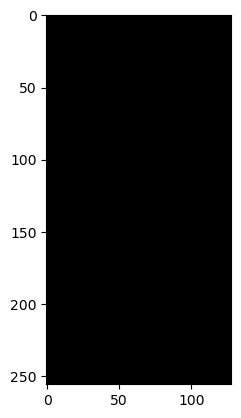

In [41]:
%matplotlib inline

plt.imshow(image_test[45], cmap='gray')

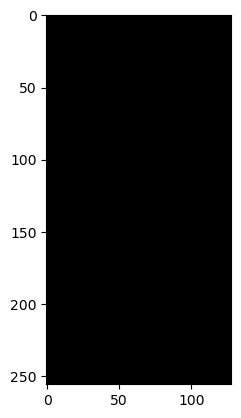

In [42]:
plt.imshow(label_test[50], cmap='gray')

FileNotFoundError: [WinError 2] The system cannot find the file specified: '200922_0_144_L_0_K.npy' -> 'EM_200922_0_144_L_0_K.npy'